In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Text data

In [34]:
with open('./Man_and_Wife.txt', 'r', encoding='utf-8') as f:
    maw_txt = f.read()

In [45]:
chapters_idx = [m.start() for m in re.finditer('CHAPTER', maw_txt)]
len(chapters_idx)

57

In [50]:
print(maw_txt[chapters_idx[-5]:chapters_idx[-5]+500])

CHAPTER THE FIFTY-THIRD.

WHAT had happened in the hours of darkness?

This was Anne’s first thought, when the sunlight poured in at her
window, and woke her the next morning.

She made immediate inquiry of the servant. The girl could only speak for
herself. Nothing had occurred to disturb her after she had gone to bed.
Her master was still, she believed, in his room. Mrs. Dethridge was at
her work in the kitchen.

Anne went to the kitchen. Hester Dethridge was at her usual occupation
at that ti


In [2]:
with open('./ВойнаИМир_Книга1_1-2_15.txt', 'r', encoding='utf-8') as f:
    txt = f.read()

In [3]:
print(txt[:1000])

Лев Николаевич Толстой

Война и мир

Том первый


Часть первая


I


– Eh bien, mon prince. Gênes et Lucques ne sont plus que des apanages, des поместья, de la famille Buonaparte. Non, je vous previens, que si vous ne me dites pas, que nous avons la guerre, si vous vous permettez encore de pallier toutes les infamies, toutes les atrocités de cet Antichrist (ma parole, j'y crois) – je ne voue connais plus, vous n'êtes plus mon ami, vous n'êtes plus мой верный раб, comme vous dites[28]. Ну, здравствуйте, здравствуйте. Je vois que je vous fais peur[29], садитесь и рассказывайте.

Так говорила в июле 1805 года известная Анна Павловна Шерер, фрейлина и приближенная императрицы Марии Феодоровны, встречая важного и чиновного князя Василия, первого приехавшего на ее вечер. Анна Павловна кашляла несколько дней, у нее был грипп, как она говорила (грипп был тогда новое слово, употреблявшееся только редкими). В записочках, разосланных утром с красным лакеем, было написано без различия во всех:

“S

In [5]:
part_1_idx = txt.find('Часть первая')
part_2_idx = txt.find('Часть вторая')
part1 = txt[len('Часть первая')+ part_1_idx:part_2_idx]
part2 = txt[part_2_idx + len('Часть вторая'):]

In [6]:
print(part1[:500])




I


– Eh bien, mon prince. Gênes et Lucques ne sont plus que des apanages, des поместья, de la famille Buonaparte. Non, je vous previens, que si vous ne me dites pas, que nous avons la guerre, si vous vous permettez encore de pallier toutes les infamies, toutes les atrocités de cet Antichrist (ma parole, j'y crois) – je ne voue connais plus, vous n'êtes plus mon ami, vous n'êtes plus мой верный раб, comme vous dites[28]. Ну, здравствуйте, здравствуйте. Je vois que je vous fais peur[29], садит


In [7]:
print(part2[:500])




I


В октябре 1805 года русские войска занимали села и города эрцгерцогства Австрийского, и еще новые полки приходили из России, отягощая постоем жителей, располагались у крепости Браунау. В Браунау была главная квартира главнокомандующего Кутузова.

11-го октября 1805 года один из только что пришедших к Браунау пехотных полков, ожидая смотра главнокомандующего, стоял в полумиле от города. Несмотря на нерусскую местность и обстановку: фруктовые сады, каменные ограды, черепичные крыши, горы, в


In [8]:
print(len(part1.split()), len(part2.split()))

39890 22839


# Preprocessing

In [9]:
from natasha import (
    Segmenter, MorphVocab,
    NewsNERTagger,
    NewsEmbedding,
    NewsMorphTagger,    
    Doc
)
import re
import glob

In [10]:
def prepare_russian_text(input_file, output_file):
    segmenter = Segmenter()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    ner_tagger = NewsNERTagger(emb)
    morph_vocab = MorphVocab()

    label_dict = {'NUM': 'ordinal1', 'PRON': 'pron1', 'PER': 'person1'}
    next_label_num = 5
    with open(input_file, encoding='utf-8') as fin:
      raw_text = ' '.join(fin.readlines()).replace('\n', ' ')
    raw_text = re.sub(r'\d+', '0' , raw_text)
    raw_text = ' '.join(re.findall(r'[А-яЁё]+', raw_text))  # remove non-cyrillic symbols

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    
    for span in reversed(doc.ner.spans):
        if span.type not in label_dict:
            label_dict[span.type] = str(next_label_num)
            next_label_num += 1
        raw_text = "".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))

    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
      
    prepared_text = ''
    prev_num = False
    for token in tqdm(doc.tokens, desc='Text preprocessing...'):
      
        if token.pos == 'NUM' and not token.text.isdigit():
            if not prev_num:
                prepared_text += '0'
                prepared_text += ' '
                prev_num = True
            continue

        prev_num = False

        if token.pos in label_dict:
            prepared_text += label_dict[token.pos]
            prepared_text += ' '
            
        elif token.pos != 'PUNCT':
                try:
                    token.lemmatize(morph_vocab)
                    prepared_text += token.lemma.lower()
                    prepared_text += ' '
                except Exception as ex:
                    prepared_text += token.text.lower()
                    prepared_text += ' '
    with open(output_file, 'w', encoding='utf-8') as fout:
       fout.write(prepared_text)

In [11]:
with open('War_and_Peace_Book1_part1.txt', 'w', encoding='utf-8') as f:
    f.write(part1)
with open('War_and_Peace_Book1_part2.txt', 'w', encoding='utf-8') as f:
    f.write(part2)

In [ ]:
# import os
# os.makedirs('preprocessed/')

In [12]:
prepare_russian_text('War_and_Peace_Book1_part1.txt', 'preprocessed/War_and_Peace_Book1_part1.txt')

Text preprocessing...:   0%|          | 0/35464 [00:00<?, ?it/s]

In [13]:
with open('preprocessed/War_and_Peace_Book1_part1.txt', 'r', encoding='utf-8') as f:
    part1_preprocessed = f.read()

In [14]:
print(part1_preprocessed[:500])

поместье мой верный раб ну здравствовать здравствовать садиться и рассказывать person ordinal1 говорить в июль год известный person ordinal1 фрейлина и приблизить императрица person ordinal1 встречая важный и чиновный князь василий первый приехать на ее вечер person ordinal1 кашлять 0 день у pron1 быть грипп как pron1 говорить грипп быть тогда новый слово употребляться только редкий в записочка разослать утро с красный лакей быть написать без различие в pron1 или отвечать нисколько не смутиться 


In [15]:
prepare_russian_text('War_and_Peace_Book1_part2.txt', 'preprocessed/War_and_Peace_Book1_part2.txt')

Text preprocessing...:   0%|          | 0/22068 [00:00<?, ?it/s]

In [16]:
with open('preprocessed/War_and_Peace_Book1_part2.txt', 'r', encoding='utf-8') as f:
    part2_preprocessed = f.read()

In [17]:
print(part2_preprocessed[:500])

в октябрь год русский войско занимать село и город эрцгерцогства ordinal1 и еще новый полок приходить из ordinal1 отягощая постоем житель располагаться у крепость ordinal1 в ordinal1 быть главный квартира главнокомандующий person ordinal1 го октябрь год 0 из только что прийти к person ordinal1 пехотный полок ожидая смотр главнокомандующий стоять в полумиля от город ordinal1 на нерусский местность и обстановка фруктовый сад каменный ограда черепичный крыша гора виднеться вдали на нерусский народ 


# Trajectories

In [18]:
wdict = np.load(
    '../../STB/DATA/russian_data/russian_nofrag_data/russian_nofraglit_SVD_dict.npy', allow_pickle=True
).item()

In [19]:
wdict['мужчина'].shape

(32,)

In [ ]:
from lib.trajectories import trajectory_from_text
part1_ts = trajectory_from_text(part1_preprocessed, wdict, wdim=32, text_length_threshold=None)

In [24]:
part1_ts.shape

(25712, 32)

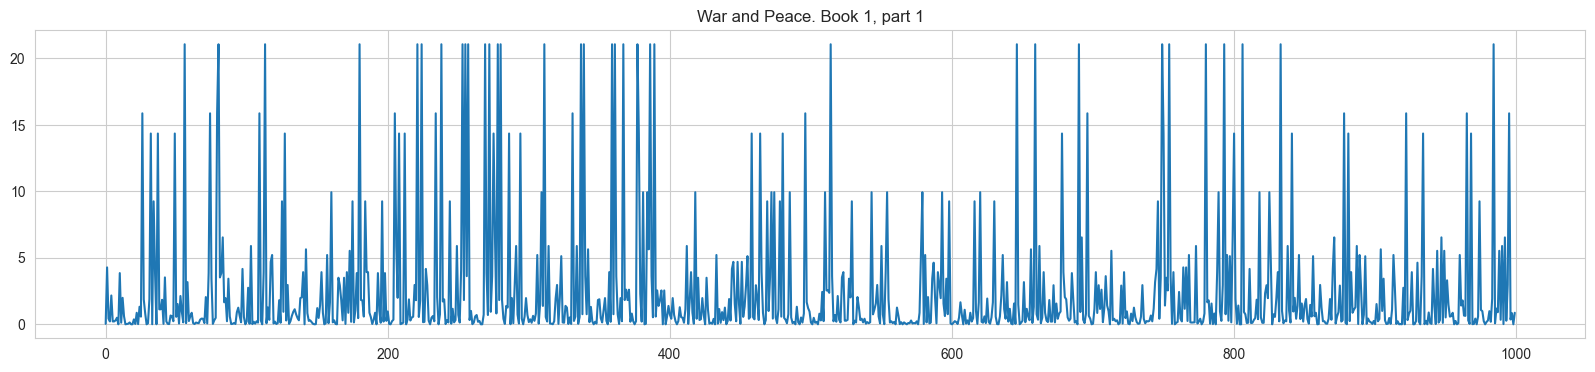

In [25]:
plt.figure(figsize=(20,4))
plt.title('War and Peace. Book 1, part 1')
plt.plot(part1_ts[:1000, 0]);

In [26]:
part2_ts = get_trajectory(part2_preprocessed, wdict)

In [27]:
part2_ts.shape

(16351, 32)

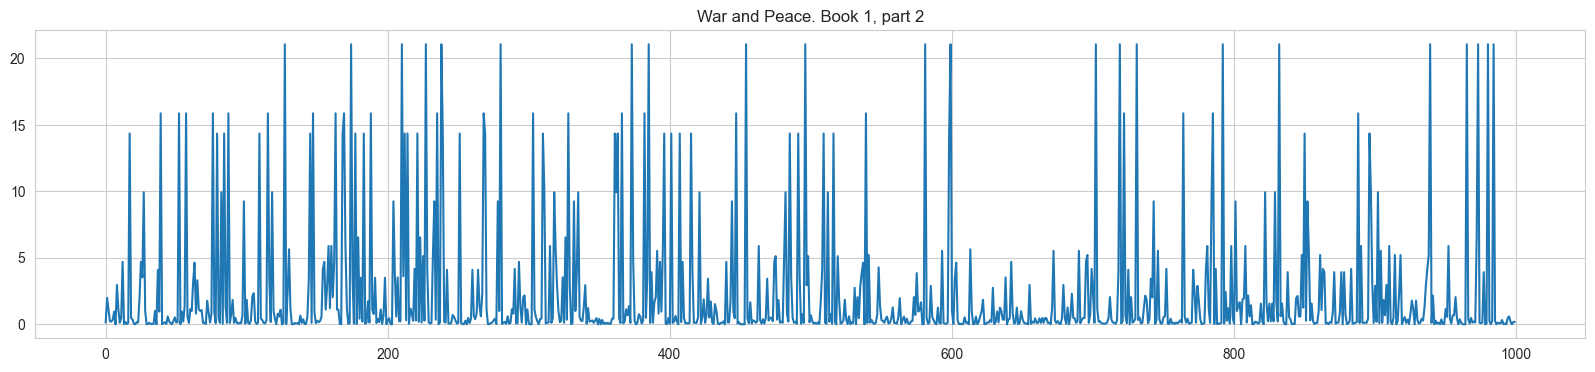

In [28]:
plt.figure(figsize=(20,4))
plt.title('War and Peace. Book 1, part 2')
plt.plot(part2_ts[:1000, 0]);